Analysis of the surface currents from CMEMS and sea ice velocities from Phy model

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import rasterio
import os
from osgeo import gdal, ogr, osr
import subprocess
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# data.close()
# data=xr.open_dataset('dataset-topaz6-arc-15min-3km-be_1622126301286.nc')
data=xr.open_dataset('dataset-topaz6-arc-15min-3km-be_1622555087601.nc')
# data.close()
# data=xr.open_dataset('try.nc')
print(data.info())

xarray.Dataset {
dimensions:
	time = 9 ;
	x = 2467 ;
	y = 2367 ;

variables:
	int32 stereographic() ;
		stereographic:grid_mapping_name = polar_stereographic ;
		stereographic:latitude_of_projection_origin = 90.0 ;
		stereographic:longitude_of_projection_origin = -45.0 ;
		stereographic:scale_factor_at_projection_origin = 1.0 ;
		stereographic:straight_vertical_longitude_from_pole = -45.0 ;
		stereographic:earth_redius = 6378273.0 ;
		stereographic:proj4 = +proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs ;
		stereographic:false_easting = 0.0 ;
		stereographic:false_northing = 0.0 ;
		stereographic:_CoordinateTransformType = Projection ;
		stereographic:_CoordinateAxisTypes = GeoX GeoY ;
	float32 model_depth(y, x) ;
		model_depth:cell_methods = area: mean ;
		model_depth:grid_mapping = stereographic ;
		model_depth:units = meter ;
		model_depth:standard_name = sea_floor_depth_below_sea_level ;
		model_depth:_ChunkSizes = [  26 2467] ;
	float32 latitude(y, x) ;
		latitude:standa

In [3]:
Yt=data.y.values
Xt=data.x.values
Uo=data.vxo.values[:,:]  
Vo=data.vyo.values[:,:]
timet=data.time.values[:] #[48::96] indexing to get time same as ocean parts
lont=np.squeeze(data.longitude.values)
latt=np.squeeze(data.latitude.values)
print(Uo.shape)
print(lont.min())
print(latt.min())
# print(Yt)
print(timet)

(9, 2367, 2467)
-179.98976
41.569187
['2018-01-01T00:00:00.000000000' '2018-01-01T00:15:00.000000000'
 '2018-01-01T00:30:00.000000000' '2018-01-01T00:45:00.000000000'
 '2018-01-01T01:00:00.000000000' '2018-01-01T01:15:00.000000000'
 '2018-01-01T01:30:00.000000000' '2018-01-01T01:45:00.000000000'
 '2018-01-01T02:00:00.000000000']


In [35]:
#Regular grid interpolator to obtain another regular grid but with less number of points in GTSM
#scipy.interpolate.RegularGridInterpolator(points, values, method='linear', bounds_error=True, fill_value=nan)
n=100
from scipy.interpolate import RegularGridInterpolator
loninterpol=RegularGridInterpolator((Yt,Xt),lont ,method='linear')
latinterpol=RegularGridInterpolator((Yt,Xt),latt, method='linear')
Xg,Yg=np.meshgrid(np.linspace(Xt.min(),Xt.max(),n),np.linspace(Yt.min(),Yt.max(),n),indexing='ij')
XYlist=np.reshape((Yg,Xg),(2,-1),order='C').T
lonts=loninterpol(XYlist)
print(XYlist[0,0],XYlist[-1,-1])
print(Xt.min(),Xt.max())
print(Yt.min(),Yt.max())
# lontsg=np.reshape(lonts,(n,n))
latts=latinterpol(XYlist)
# latsg=np.reshape(latts,(n,n))

-43.0 37.97999954223633
-36.0 37.98
-43.0 27.98


In [36]:
#getting U and V values at the above points.
ti=0
Uinterpol=RegularGridInterpolator((Yt,Xt),Uo[ti,:], method='linear')
Vinterpol=RegularGridInterpolator((Yt,Xt),Vo[ti,:], method='linear')
Uts=Uinterpol(XYlist)
# Utsg=np.reshape(Uts,(n,n))
# print(latsg.shape)
Vts=Vinterpol(XYlist)
print(Vts.shape)
# Vtsg=np.reshape(Vts,(n,n))

(10000,)


In [37]:
Umag=np.sqrt(Uts**2+Vts**2)

In [38]:
##getting colormap from inger mat file.
import scipy.io
mat = scipy.io.loadmat('pinkmap.mat')
# print(mat)
from matplotlib import colors
def array2cmap(X):
    X = np.c_[X,np.ones(len(X))]
    return colors.LinearSegmentedColormap.from_list('pinkmap', X)
pinkmapinger = array2cmap(mat['pinkmap'])

In [23]:
# skip=(slice(None,None,100))
# fig=plt.figure(figsize=(12, 8))
# cmap=pinkmapinger
# #     level=np.linspace(0,1.5,25) for contours 
# ax=fig.add_subplot(projection=ccrs.NorthPolarStereo( central_longitude=0,globe=None)) 
# ax.set_extent((-180, 180, 50, 90), crs=ccrs.PlateCarree())
# feature=cpf.GSHHSFeature(scale='auto',levels=[1],facecolor='black',alpha=0.5,edgecolor='none')
# ax.add_feature(feature)
# cont=ax.pcolormesh(lont,latt,Umag,transform=ccrs.PlateCarree(central_longitude=0),vmax=1.0,cmap=cmap,shading='gouraud')
# # cont=ax.contourf(lont,latt,np.squeeze(tempUo),transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,levels=50)
# # plt.colorbar(cont)
# # plt.quiver(lont[skip,skip],latt[skip,skip],Uo[0,skip,skip],Vo[0,skip,skip],transform=ccrs.PlateCarree(),units='xy')
# # plt.show()


Obtaining GTSM values at some points from the above grid and comparing those.

In [39]:
gtsmdata=xr.open_dataset('gtsm_newpoints_his.nc')
gtsmdata.info()

xarray.Dataset {
dimensions:
	nFlowElemContourPts = 4 ;
	nFlowElemWithBnd = 23748 ;
	nFlowLink = 42701 ;
	nFlowLinkPts = 2 ;
	nNetLink = 45212 ;
	nNetLinkPts = 2 ;
	station_geom_nNodes = 10000 ;
	stations = 10000 ;
	time = 3649 ;

variables:
	float64 FlowElem_xcc(nFlowElemWithBnd) ;
		FlowElem_xcc:units = degrees_east ;
		FlowElem_xcc:standard_name = longitude ;
		FlowElem_xcc:long_name = x-coordinate of flow element circumcenter ;
		FlowElem_xcc:bounds = FlowElemContour_x ;
	float64 FlowElem_ycc(nFlowElemWithBnd) ;
		FlowElem_ycc:units = degrees_north ;
		FlowElem_ycc:standard_name = latitude ;
		FlowElem_ycc:long_name = y-coordinate of flow element circumcenter ;
		FlowElem_ycc:bounds = FlowElemContour_y ;
	float64 FlowElem_zcc(nFlowElemWithBnd) ;
		FlowElem_zcc:standard_name = bed_level ;
		FlowElem_zcc:long_name = bed level of flow element ;
	float64 FlowElem_bac(nFlowElemWithBnd) ;
		FlowElem_bac:long_name = flow element area ;
		FlowElem_bac:units = m2 ;
		FlowElem_bac:standard_n

In [29]:
longtsm=gtsmdata.station_x_coordinate.values
latgtsm=gtsmdata.station_y_coordinate.values
Ugtsm=gtsmdata.x_velocity.values[96*7:,:]
Vgtsm=gtsmdata.y_velocity.values[96*7:,:]
stations=gtsmdata.station_name.values
timegt=gtsmdata.time.values
print(timegt)
print(longtsm.shape)

['2017-12-25T00:00:00.000000000' '2017-12-25T00:15:00.000000000'
 '2017-12-25T00:30:00.000000000' ... '2018-01-31T23:30:00.000000000'
 '2018-01-31T23:45:00.000000000' '2018-02-01T00:00:00.000000000']
(10000,)


In [40]:
import math
from statistics import mean
diffU=Uts-Ugtsm[ti,:]
diffV=Vts-Vgtsm[ti,:]
diffmag=np.sqrt(diffU**2+diffV**2)
print(mean(i for i in diffmag if not math.isnan(i)))

0.14968637029481954


In [41]:
#getting data on a regular grid.
long,latg=np.meshgrid(np.linspace(lonts.min(),lonts.max(),30000),np.linspace(latts.min(),latts.max(),30000))
from scipy.interpolate import griddata
diffgrid = griddata((lonts,latts), diffmag, (long, latg), method='linear')
diffUgrid = griddata((lonts,latts), diffU, (long, latg), method='linear')
diffVgrid = griddata((lonts,latts), diffV, (long, latg), method='linear')

MemoryError: Unable to allocate 6.71 GiB for an array with shape (900000000, 1) and data type float64

In [ ]:
skip=(slice(None,None,50))
fig=plt.figure(figsize=(12, 8))
cmap=pinkmapinger
#     level=np.linspace(0,1.5,25) for contours 
ax=fig.add_subplot(projection=ccrs.NorthPolarStereo( central_longitude=0,globe=None)) 
ax.set_extent((-180, 180, 50, 90), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='auto',levels=[1],facecolor='black',alpha=0.5,edgecolor='none')
ax.add_feature(feature)
# cont=ax.pcolormesh(lontsg,latsg,Utsg,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,shading='gouraud')
feature=cpf.GSHHSFeature(scale='auto',levels=[1],facecolor='black',alpha=0.5,edgecolor='none')
ax.add_feature(feature)
cont=plt.scatter(lonts,latts,c=diffmag,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap)
plt.colorbar(cont)
plt.quiver(long[skip,skip],latg[skip,skip],diffUgrid[skip,skip],diffVgrid[skip,skip],transform=ccrs.PlateCarree(),units='xy')
# plt.show()
plt.savefig('Diff_gtsm-Arcticcmems',dpi=500)

Below part was for 5840 points. 

In [43]:
loncmem=lont.ravel()[::1000]
latcmem=latt.ravel()[::1000]
Ucmem=Uo[0,:].ravel()[::1000]
Vcmem=Vo[0,:].ravel()[::1000]
print(loncmem.size)
print(Ucmem.shape)

5840
(5840,)


In [44]:
import math
from statistics import mean
diffU=Ucmem-Ugtsm[0,:]
diffV=Vcmem-Vgtsm[0,:]
diffmag=np.sqrt(diffU**2+diffV**2)
print(mean(i for i in diffmag if not math.isnan(i)))
#2d array
# lon2d=np.reshape(loncmem,(73,80))
# lat2d=np.reshape(latcmem,(73,80))
# diffmag2d=np.reshape(diffmag,(73,80))
# diffU2d=np.reshape(diffU,(73,80))
# diffv2d=np.reshape(diffV,(73,80))

0.14442847537657522


In [11]:
#getting data on a regular grid.
long,latg=np.meshgrid(np.linspace(loncmem.min(),loncmem.max(),3000),np.linspace(latcmem.min(),latcmem.max(),3000))
from scipy.interpolate import griddata
diffgrid = griddata((loncmem,latcmem), diffmag, (long, latg), method='linear')
diffUgrid = griddata((loncmem,latcmem), diffU, (long, latg), method='linear')
diffVgrid = griddata((loncmem,latcmem), diffV, (long, latg), method='linear')

In [12]:
skip=(slice(None,None,50),slice(None,None,50))
fig=plt.figure(figsize=(12, 8))
cmap=pinkmapinger
#     level=np.linspace(0,1.5,25) for contours 
ax=fig.add_subplot(projection=ccrs.NorthPolarStereo( central_longitude=0,globe=None)) 
ax.set_extent((-180, 180, 50, 90), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='auto',levels=[1],facecolor='black',alpha=0.5,edgecolor='none')
ax.add_feature(feature)
cont=ax.pcolormesh(long,latg,diffgrid,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,shading='gouraud')
# cont=ax.contourf(lont,latt,np.squeeze(tempUo),transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,levels=50)
plt.colorbar(cont)
plt.quiver(long[skip],latg[skip],diffUgrid[skip],diffVgrid[skip],transform=ccrs.PlateCarree(),units='xy')
# plt.show()
# cont=ax.pcolormesh(lont.ravel(),latt.ravel(),Umag.ravel(),transform=ccrs.PlateCarree(central_longitude=0),vmax=1.0,cmap=cmap,shading='gouraud')
plt.savefig('difference_2_gtsmt2018_1.jpg',dpi=500)

NameError: name 'pinkmapinger' is not defined

<Figure size 864x576 with 0 Axes>

In [5]:
#Regular grid interpolator to obtain another regular grid but with less number of points in GTSM
#scipy.interpolate.RegularGridInterpolator(points, values, method='linear', bounds_error=True, fill_value=nan)
n=100
from scipy.interpolate import RegularGridInterpolator
loninterpol=RegularGridInterpolator((Yt,Xt),lont ,method='linear')
latinterpol=RegularGridInterpolator((Yt,Xt),latt, method='linear')
Xg,Yg=np.meshgrid(np.linspace(Xt.min(),Xt.max(),n),np.linspace(Yt.min(),Yt.max(),n),indexing='ij')
XYlist=np.reshape((Yg,Xg),(2,-1),order='C').T
lonts=loninterpol(XYlist)
print(XYlist[0,0],XYlist[-1,-1])
print(Xt.min(),Xt.max())
print(Yt.min(),Yt.max())
lontsg=np.reshape(lonts,(n,n))
latts=latinterpol(XYlist)
latsg=np.reshape(latts,(n,n))

-43.0 37.97999954223633
-36.0 37.98
-43.0 27.98


In [23]:
# gridlon,gridlat=np.meshgrid(lonts,latts)


In [14]:
#getting U and V values at the above points.
ti=0
Uinterpol=RegularGridInterpolator((Yt,Xt),Uo[ti,:], method='linear')
Vinterpol=RegularGridInterpolator((Yt,Xt),Vo[ti,:], method='linear')
Uts=Uinterpol(XYlist)
Utsg=np.reshape(Uts,(n,n))
print(latsg.shape)
Vts=Vinterpol(XYlist)
print(Vts.shape)
Vtsg=np.reshape(Vts,(n,n))

(100, 100)
(10000,)


In [17]:
# from scipy.interpolate import griddata
# gridUt=griddata((lonts,latts),Uts,(gridlon,gridlat))

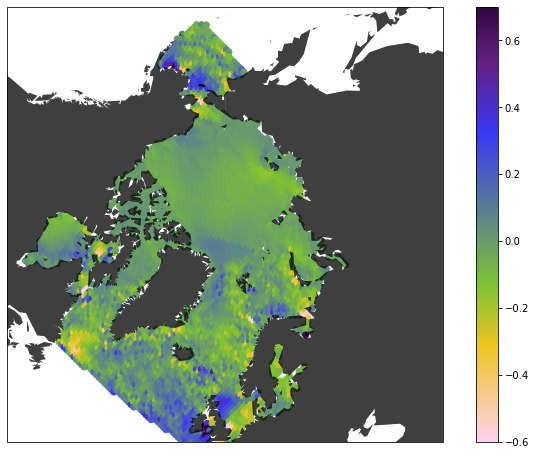

In [22]:
skip=(slice(None,None,100))
fig=plt.figure(figsize=(12, 8))
cmap=pinkmapinger
#     level=np.linspace(0,1.5,25) for contours 
ax=fig.add_subplot(projection=ccrs.NorthPolarStereo( central_longitude=0,globe=None)) 
ax.set_extent((-180, 180, 50, 90), crs=ccrs.PlateCarree())
feature=cpf.GSHHSFeature(scale='auto',levels=[1],facecolor='black',alpha=0.5,edgecolor='none')
ax.add_feature(feature)
# cont=ax.pcolormesh(lontsg,latsg,Utsg,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,shading='gouraud')
feature=cpf.GSHHSFeature(scale='auto',levels=[1],facecolor='black',alpha=0.5,edgecolor='none')
ax.add_feature(feature)
cont=plt.scatter(lonts,latts,c=Uts,transform=ccrs.PlateCarree(central_longitude=0),vmin=-0.6,vmax=0.7,cmap=cmap)
plt.colorbar(cont)
# plt.quiver(lont[skip,skip],latt[skip,skip],Uo[0,skip,skip],Vo[0,skip,skip],transform=ccrs.PlateCarree(),units='xy')
# plt.show()

In [171]:
num=len(lonts)
pointnames= (np.linspace(1,num,num)).astype(int).astype("str")
print(pointnames)
# pointnames=np.array2string(pointnames,precision=int)
pointnames=np.core.defchararray.add("\'",pointnames)
pointnames=np.core.defchararray.add(pointnames,"\'")
# print(np.shape(np.squeeze(lont)))
print(pointnames)
np.savetxt('points.xyn', np.c_[lonts, latts.ravel(), pointnames],fmt=["%s", "%s","%s"],delimiter='\t')

['1' '2' '3' ... '9998' '9999' '10000']
["'1'" "'2'" "'3'" ... "'9998'" "'9999'" "'10000'"]


In [7]:
num=len(lonts.ravel())
pointnames= (np.linspace(1,num+1,num+1)).astype(int).astype("str")
print(pointnames)
# pointnames=np.array2string(pointnames,precision=int)
pointnames=np.core.defchararray.add("\'",pointnames)
pointnames=np.core.defchararray.add(pointnames,"\'")
# print(np.shape(np.squeeze(lont)))
print(pointnames)
np.savetxt('points.xyn', np.c_[lont.ravel()[::1000], latt.ravel()[::1000], pointnames],fmt=["%s", "%s","%s"],delimiter='\t')

['1' '2' '3' ... '5838' '5839' '5840']
["'1'" "'2'" "'3'" ... "'5838'" "'5839'" "'5840'"]


In [17]:
#projection of polar sterogrpahic values by rotation as per CMEMS. 
nx=np.size(data.longitude.values,0)
ny=np.size(data.longitude.values,1)
radian=np.pi/180.
dlon_ip1=np.multiply(np.cos(radian*0.5*(latt[1:nx,:]+latt[0:nx-1,:])),(lont[1:nx,:]-lont[0:nx-1,:]))

dlat_ip1=latt[1:nx,:]-latt[0:nx-1,:];
dlon_ip1=np.vstack((dlon_ip1,dlon_ip1[nx-2,:]))
dlat_ip1=np.vstack((dlat_ip1,dlat_ip1[nx-2,:]))
print(dlon_ip1.shape)
theta_ip1=np.arctan2(dlat_ip1,dlon_ip1) #angle displacement with constant latitude lines
theta_jp1=theta_ip1+90*radian
theta_ip1.shape
#rotated easterly and northerly components
tempUo=np.multiply(Uo[0,:],np.cos(theta_ip1))+np.multiply(Vo[0,:],np.cos(theta_jp1))
tempVo=np.multiply(Uo[0,:],np.sin(theta_ip1))+np.multiply(Vo[0,:],np.sin(theta_jp1))

1

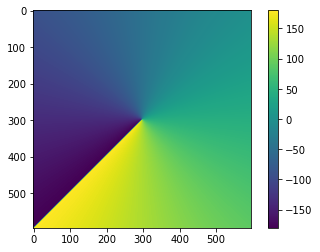

In [60]:
mat=lont
xtg,ytg=np.meshgrid(Xt,Yt)
# c=plt.contourf(xtg,ytg,latt)
# plt.colorbar(c)
c=plt.imshow(mat)
plt.colorbar(c)

In [84]:
from pyproj import Proj, transform
x1=Xt[0];y1=Yt[0]

OutProj=Proj('epsg:4326')
# InProj=Proj('+proj=stere +lon_0=-45 +lat_0=+90  +k=1 +x_0=0 +y_0=0 +R=6378273 +no_defs +units=km +datum=WGS84',preserve_units=True)
InProj=Proj('+units=km +proj=stere +a=6378273.0 +b=6378273.0 +lon_0=-45.0 +lat_0=90.0 +lat_ts=90.0')
# InProj=Proj('+proj=ups +units=km +north +lon_0=-45  +ellips=WGS84')
tlat,tlon=transform(InProj,OutProj,ytg,xtg)
# print(tlon)
# print(tlat)
# print(x1)
# print(y1)

<ipython-input-84-3ea741c44d14>:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  tlat,tlon=transform(InProj,OutProj,ytg,xtg)


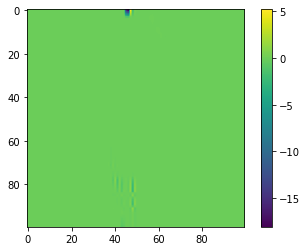

In [54]:
mat=Uogrid
xtg,ytg=np.meshgrid(Xt,Yt)
# c=plt.contourf(xtg,ytg,latt)
# plt.colorbar(c)
c=plt.imshow(mat)
plt.colorbar(c)

In [42]:
data.close()

In [43]:
from scipy.interpolate import interp2d
i=100; j=150
interpolant=interp2d(lont[i:j,i:j],latt[i:j,i:j],tempUo[i:j,i:j],kind='linear')

/u/vasulkar/.conda/envs/plotting/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=58,47 m=2500 fp=0.000026 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [44]:
lon0=lont[i:j,i:j].min();lon1=lont[i:j,i:j].max()
lat0=latt[i:j,i:j].min();lat1=latt[i:j,i:j].max()
gridlon,gridlat=np.meshgrid(np.linspace(lon0,lon1,100),np.linspace(lat0,lat1,100))
Uogrid=interpolant(np.linspace(lon0,lon1,100),np.linspace(lat0,lat1,100))

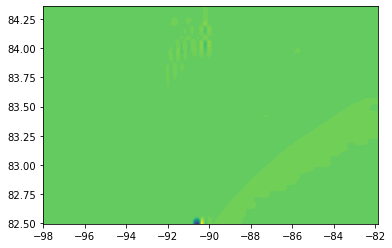

In [48]:
plt.contourf(gridlon,gridlat,Uogrid,levels=50)
# plt.imshow(Uogrid)

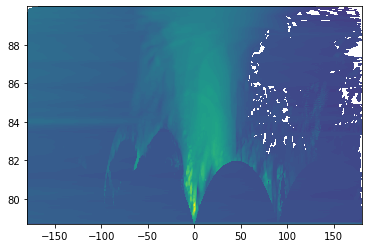

In [47]:
plt.contourf(lont,latt,tempUo,levels=100)

In [6]:
dataice=xr.open_dataset('CMEMSIcedaily.nc')
print(dataice.info())

xarray.Dataset {
dimensions:
	latitude = 25 ;
	longitude = 4320 ;
	time = 2 ;

variables:
	float32 siconc(time, latitude, longitude) ;
		siconc:long_name = Ice concentration ;
		siconc:standard_name = sea_ice_area_fraction ;
		siconc:units = 1 ;
		siconc:unit_long = Fraction ;
		siconc:cell_methods = area: mean where sea_ice ;
	float32 latitude(latitude) ;
		latitude:valid_min = 82.0 ;
		latitude:valid_max = 84.0 ;
		latitude:step = 0.08333587646484375 ;
		latitude:units = degrees_north ;
		latitude:unit_long = Degrees North ;
		latitude:long_name = Latitude ;
		latitude:standard_name = latitude ;
		latitude:axis = Y ;
		latitude:_CoordinateAxisType = Lat ;
	float32 usi(time, latitude, longitude) ;
		usi:long_name = Sea ice eastward velocity ;
		usi:standard_name = eastward_sea_ice_velocity ;
		usi:units = m s-1 ;
		usi:unit_long = Meters per second ;
		usi:cell_methods = area: mean where sea_ice ;
	datetime64[ns] time(time) ;
		time:long_name = Time (hours since 1950-01-01) ;
		time:s

In [249]:
Xo=dataice.longitude.values
Yo=dataice.latitude.values
Ui=dataice.usi.values
Vi=dataice.vsi.values
timeo=dataice.time.values
print(Ui[0,:].shape)
print(Xo)

(25, 4320)
[-180.      -179.91667 -179.83333 ...  179.75     179.83333  179.91667]


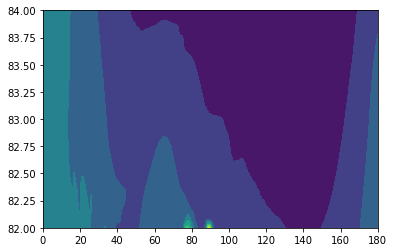

In [226]:
Xog,Yog=np.meshgrid(np.linspace(Xo[0],Xo[-1],len(Xo)),np.linspace(Yo[0],Yo[-1],len(Yo)))
plt.contourf(Xog,Yog,Ui[0,:])


In [250]:
print(timet)
print(timeo)

['2019-01-01T12:00:00.000000000' '2019-01-02T12:00:00.000000000']
['2019-01-01T12:00:00.000000000' '2019-01-02T12:00:00.000000000']


In [259]:
from scipy.interpolate import interp2d
from pyproj import Proj, transform
inProj = Proj('epsg:3995')
outProj = Proj('epsg:4326')
timeindex=0
# points=np.vstack((Xo,Yo))
interpolantu=interp2d(Xo,Yo,Ui[timeindex,:])
interpolantv=interp2d(Xo,Yo,Vi[timeindex,:])
# uiinterp=interpolant(Xt,Yt)
Uii=np.zeros(np.shape(Xt))
Vii=np.zeros(np.shape(Yt))
for i in range(len(Xt[:,0])):
    for j in range(len(Xt[0,:])):
x2,y2 = transform(inProj,outProj,x1,y1)

        Uii[i,j]=interpolantu(Xt[i,j],Yt[i,j])
        Vii[i,j]=interpolantv(Xt[i,j],Yt[i,j])

In [260]:
diffU=Uo[timeindex,:]-Uii
diffV=Uo[timeindex,:]-Vii
diffmag=np.sqrt(diffU**2+diffV**2)

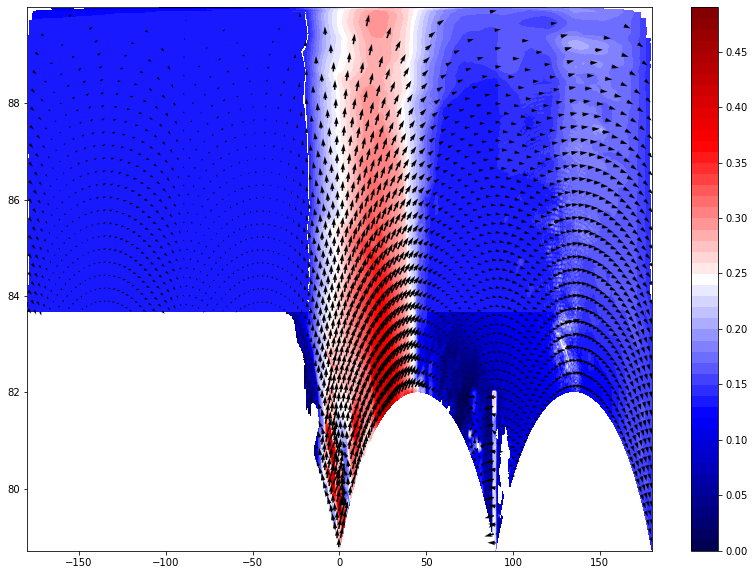

In [279]:
fig=plt.figure(figsize=(14,10))
cmap='seismic'
skip=(slice(None,None,10),slice(None,None,10))
# plt.show()
cont=plt.contourf(Xt,Yt,diffmag,levels=50,cmap=cmap)
plt.colorbar(cont)
plt.quiver(Xt[skip],Yt[skip],diffU[skip],diffV[skip],units='xy')
plt.show()

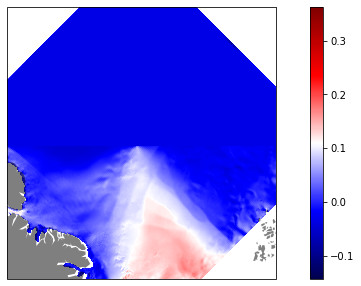

In [ ]:
!ls
filename = 'CMEMSTidal.nc'
src_name=os.path.basename(filename).split('.')[0]
driver = ogr.GetDriverByName('netCDF')
src_ds= driver.Open(filename,1)
src_layer = src_ds.GetLayer()
src_spatialRef = src_layer.GetSpatialRef()
dst_spatialRef = osr.SpatialReference()
proj4strepsg='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' #obtained from EPSG proj4 file
dst_spatialRef.ImportFromProj4(proj4strepsg)
# create the CoordinateTransformation
coordTrans = osr.CoordinateTransformation(src_spatialRef, dst_spatialRef)

In [ ]:
def reproj(file):
    # reprojecting the buffer layer to epsg 4326
    src_name=os.path.basename(file).split('.')[0]
    driver = ogr.GetDriverByName('netCDF')
    src_ds= driver.Open(file,1)
    src_layer = src_ds.GetLayer()
    src_spatialRef = src_layer.GetSpatialRef()

    dst_spatialRef = osr.SpatialReference()
    proj4strepsg='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' #obtained from EPSG proj4 file
    dst_spatialRef.ImportFromProj4(proj4strepsg)
    # create the CoordinateTransformation
    coordTrans = osr.CoordinateTransformation(src_spatialRef, dst_spatialRef)

    # create the output layer
    prjbuffilname='CMEMSTidalproj'
    prjbuffile =os.path.dirname(file)+'/'+ prjbuffilname+ '.nc'
    if os.path.exists(prjbuffile):
        driver.DeleteDataSource(prjbuffile)
    dst_ds = driver.CreateDataSource(prjbuffile)
    dst_layer =dst_ds.CreateLayer("NC_4326", geom_type=ogr.wkbMultiPolygon)
    # add fields
    inLayerDefn = src_layer.GetLayerDefn()
    for i in range(0, inLayerDefn.GetFieldCount()):
        fieldDefn = inLayerDefn.GetFieldDefn(i)
        dst_layer.CreateField(fieldDefn)
    # get the output layer's feature definition
    outLayerDefn = dst_layer.GetLayerDefn()
    # loop through the input features
    inFeature = src_layer.GetNextFeature()
    while inFeature:
        # get the input geometry
        geom = inFeature.GetGeometryRef()
        # reproject the geometry
        geom.Transform(coordTrans)
        # create a new feature
        outFeature = ogr.Feature(outLayerDefn)
        # set the geometry and attribute
        outFeature.SetGeometry(geom)
        for i in range(0, outLayerDefn.GetFieldCount()):
            outFeature.SetField(outLayerDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
            # add the feature to the shapefile
            dst_layer.CreateFeature(outFeature)
            # dereference the features and get the next input feature
            outFeature = None
            inFeature = src_layer.GetNextFeature()
        # Save and close the shapefiles
    src_ds = None
    dst_ds = None
    return(prjbuffile) 
f=reproj(filename)

In [ ]:
from osgeo import gdal

filename = 'CMEMSTidal.nc'
input_raster = gdal.Open(filename)
output_raster = 'CMEMSTidal_projected.nc'
warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')
warp = None # Closes the files